In [27]:
# Essential imports
from __future__ import annotations

import numpy as np
import networkx as nx

from graphix import Circuit, Statevec, Pattern, command
from graphix.pauli import Pauli
from graphix.ops import Ops
from graphix.states import BasicStates
import graphix.instruction as instruction
from graphix.fundamentals import Plane

import mentpy as mp

## Testing Mentpy

(<Figure size 800x300 with 1 Axes>, <Axes: >)

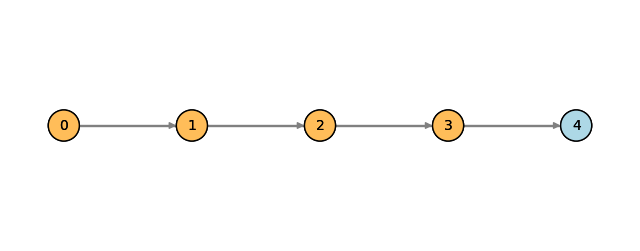

In [28]:
gs = mp.GraphState()
gs.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4)])
mbcirc = mp.MBQCircuit(gs, input_nodes=[0], output_nodes=[4])
mp.draw(mbcirc)

(<Figure size 800x300 with 1 Axes>, <Axes: >)

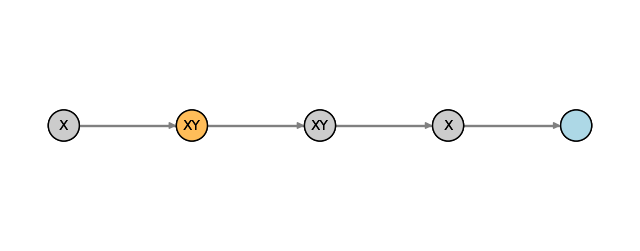

In [29]:
mbcirc[0] = mp.Ment('X')
mbcirc[1] = mp.Ment('XY')
mbcirc[2] = mp.Ment(0.5, 'XY')
mbcirc[3] = mp.Ment('X')
mp.draw(mbcirc, label='planes')

(<Figure size 800x300 with 1 Axes>, <Axes: >)

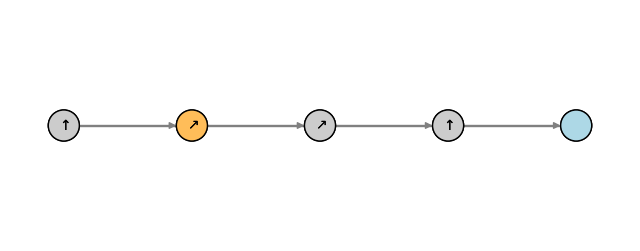

In [30]:
measurements = {0: mp.Ment('X'), 1: mp.Ment('XY'), 2: mp.Ment(0.5, 'XY'), 3: mp.Ment('X')}
mbcirc = mp.MBQCircuit(gs, input_nodes=[0], output_nodes=[4], measurements=measurements)
mp.draw(mbcirc, label='arrows')

In [31]:
mbcirc = mp.MBQCircuit(gs, input_nodes=[0], output_nodes=[4],
                     measurements={1: mp.Ment('XY')},
                     default_measurement=mp.Ment('X'))
print(mbcirc[0]) # Not specified in the constructor
print(mbcirc[1]) # Specified in the constructor
print(mbcirc[2].matrix()) # Matrix of the measurement operator

Ment(0, X)
Ment(θ, XY)
[[0 1]
 [1 0]]


(<Figure size 800x300 with 1 Axes>, <Axes: >)

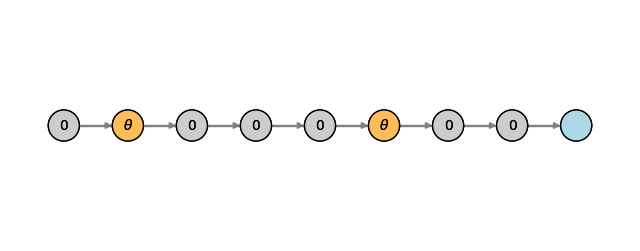

In [32]:
new_circ = mp.merge(mbcirc, mbcirc, along=[(4,0)])  # specify nodes to merge
mp.draw(new_circ, label='angles')

(<Figure size 800x300 with 1 Axes>, <Axes: >)

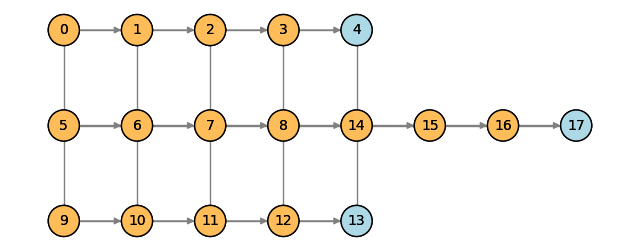

In [33]:
grid_cluster = mp.templates.grid_cluster(3, 5)
linear_cluster = mp.templates.linear_cluster(4)
grid_and_linear = mp.merge(grid_cluster, linear_cluster, along=[(9,0)])
mp.draw(grid_and_linear)

## Lie algebra part

In [34]:
ops = mp.utils.calculate_lie_algebra(grid_cluster)
print(len(ops))
ops[:3]

64


IIZ
IIX
IXZ

In [35]:
# calculate_lie_algebra breaks down into calculating the generators of the algebra (calculate_gens)
# and then completing the algebra (lie_algebra_completion).

gens = mp.utils.calculate_gens(grid_cluster)
print(gens)


IIZ
IIX
IXZ
XZI
IZI
IXI
XZX
ZXZ
ZII
XII
ZXI
IZX


In [36]:
# Generators are calculated and a subset for the output nodes is selected.
# What is needed for the generators:
# - Flow for the graph state
# - "Trainable nodes" (what nodes have not been allocated a measurement angle)
# - Function to calculate generating operator for a node (either the measurement operator or some power of it)
# - Collection of these for all "trainable nodes" is the complete generating set
# - I don't quite understand the calculation of the generating operator for a node yet **

## Testing with Graphix

In [37]:
def graphix_pattern_to_mentpy(pattern: Pattern) -> mp.MBQCircuit:
    """Convert a Graphix pattern to a MentPy MBQCircuit.
    
    Parameters
    ----------
    pattern: graphix.Pattern
        Graphix pattern object
    
    Returns
    -------
    result: mentpy.MBQCircuit
        MentPy MBQCircuit object
    """
    nodes, edges = pattern.get_graph()
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    vin = pattern.input_nodes if pattern.input_nodes is not None else []
    vout = pattern.output_nodes
    measurements = {}
    meas_planes = pattern.get_meas_plane().items()
    meas_angles = pattern.get_angles()
    for i, plane in enumerate(meas_planes):
        plane_str = str(plane[1]).split('.')[1]  # convert to 'XY', 'YZ', or 'XZ' strings
        if i in vout:
            continue
        measurements[i] = mp.Ment(meas_angles[i], plane_str)
    return mp.MBQCircuit(g, input_nodes=vin, output_nodes=vout, measurements=measurements)

In [38]:
def _mentpy_pauli_to_graphix_pauli(generators: list[mp.operators.pauliop.PauliOp]) -> list[list[Pauli]]:
    """Helper function to convert a list of MentPy Pauli operators into Graphix format.
    
    Parameters
    ----------
    generators: list[mentpy.operators.pauliop.PauliOp]
        List of MentPy Pauli operators
    
    Returns
    -------
    result: list[list[Pauli]]
        List of list of Graphix Pauli operators
    """
    output_generator_list = []
    for generator in generators:
        output_generator = []
        generator_as_list = list(str(generator))
        for pauli in generator_as_list:
            if str(pauli) == "X":
                output_generator.append(Pauli.X)
            elif str(pauli) == "Y":
                output_generator.append(Pauli.Y)
            elif str(pauli) == "Z":
                output_generator.append(Pauli.Z)
            elif str(pauli) == "I":
                output_generator.append(Pauli.I)
            else:
                raise ValueError("The element is not a Pauli")
        output_generator_list.append(output_generator)
    return output_generator_list

In [39]:
def calculate_lie_algebra(pattern: Pattern) -> list[list[Pauli]]:
    """Calculate the Lie algebra for a Graphix MBQC pattern using MentPy utils.
    
    Parameters
    ----------
    pattern: Pattern
        Pattern from Graphix
    
    Returns
    -------
    result: list[list[Pauli]]
        List of list of Graphix Pauli gates
    """
    lie_algebra = mp.utils.calculate_lie_algebra(graphix_pattern_to_mentpy(pattern))
    print(lie_algebra)
    return _mentpy_pauli_to_graphix_pauli(lie_algebra)

In [52]:
def mentpy_to_graphix_pattern(graph: mp.MBQCircuit) -> Pattern:
    """Convert a MentPy MBQCircuit to a Graphix pattern.
    
    Parameters
    ----------
    graph: mentpy.MBQCircuitdef mentpy_pauli_to_graphix(generators: list[mp.operators.pauliop.PauliOp]) -> list[list[Ops]]:
    output_generator_list = []
    
    Returns
    -------
    result: graphix.Pattern
        Graphix pattern object
    """
    conversion_dict = {"XY": Plane.XY, "YZ": Plane.YZ, "XZ": Plane.XZ}
    new_nodes: list[int] = list(graph.inputc)
    edges: list[tuple[int,int]] = [e for e in graph.edges]
    input_nodes = graph.input_nodes
    m_commands: dict[int, command.M] = {}    
    if graph.measurements is not None:
        for node, measurement in graph.measurements.items():
            if measurement is not None:
                m_commands[node] = command.M(node, plane=conversion_dict[measurement.plane], angle=measurement.angle)
    for node in graph.outputc:
        if node not in graph.measurements:
            m_commands[node] = command.M(node)
    
    pattern = Pattern(input_nodes, None, None)
    pattern.extend((command.N(node) for node in new_nodes), (command.E(edge) for edge in edges), (m_command for m_command in m_commands.values()))
    return pattern

Flow detected in the graph.


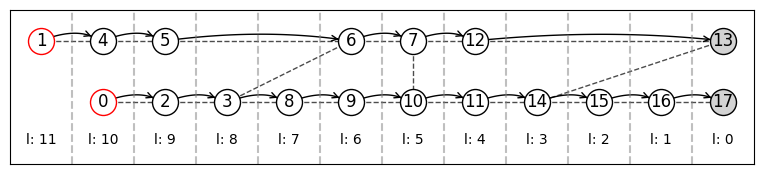

XI
II
[[Pauli.X, Pauli.I], [Pauli.I, Pauli.I]]


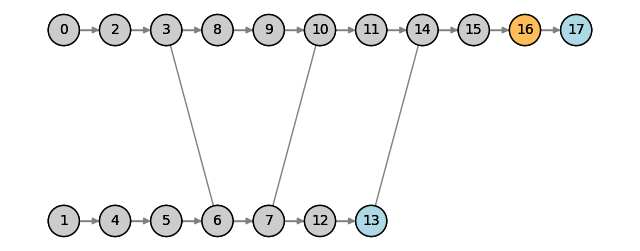

In [53]:
circuit = Circuit(2)

# apply rotation gates
theta = np.random.default_rng().random(4)
circuit.rz(0, theta[0])
circuit.rz(1, theta[1])
circuit.cnot(0, 1)
circuit.s(0)
circuit.cnot(1, 0)
circuit.rz(1, theta[2])
circuit.cnot(1, 0)
circuit.rz(0, theta[3])

pattern = circuit.transpile().pattern
pattern.draw_graph(flow_from_pattern=False)

test_pattern = graphix_pattern_to_mentpy(pattern)
mp.draw(test_pattern)

print(calculate_lie_algebra(pattern))

Flow detected in the graph.


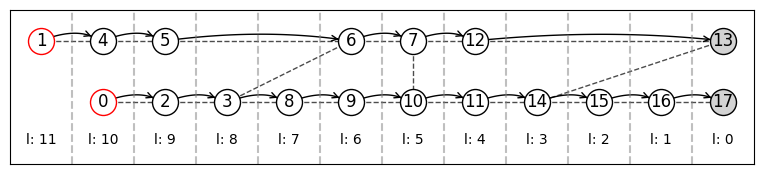

In [ ]:
return_pattern = mentpy_to_graphix_pattern(test_pattern)
return_pattern.draw_graph(flow_from_pattern=False)

In [1]:
"""Graphix interface for the MentPy package.

Copyright (C) 2025, QAT team (ENS-PSL, Inria, CNRS).

ref: MentPy: A Python package for parametrized MBQC circuits
Mantilla Calderón, Luis
https://github.com/mentpy/mentpy
"""
from __future__ import annotations

import networkx as nx
from graphix import Pattern, command
from graphix.fundamentals import Plane
from graphix.gflow import find_flow
from graphix.opengraph import OpenGraph
from graphix.pauli import Pauli

import mentpy as mp


def graphix_pattern_to_mentpy(pattern: Pattern) -> mp.MBQCircuit:
    """Convert a Graphix pattern to a MentPy MBQCircuit.

    Parameters
    ----------
    pattern: graphix.Pattern
        Graphix pattern object

    Returns
    -------
    result: mentpy.MBQCircuit
        MentPy MBQCircuit object

    """
    nodes, edges = pattern.get_graph()
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    vin = pattern.input_nodes if pattern.input_nodes is not None else []
    vout = pattern.output_nodes
    measurements = {}
    meas_planes = pattern.get_meas_plane().items()
    meas_angles = pattern.get_angles()
    for i, plane in enumerate(meas_planes):
        plane_str = str(plane[1]).split(".")[1]  # convert to 'XY', 'YZ', or 'XZ' strings
        if i in vout:
            continue
        measurements[i] = mp.Ment(meas_angles[i], plane_str)
    return mp.MBQCircuit(g, input_nodes=vin, output_nodes=vout, measurements=measurements)


def mentpy_to_graphix_pattern(graph: mp.MBQCircuit) -> Pattern:
    """Convert a MentPy MBQCircuit to a Graphix pattern.

    Parameters
    ----------
    graph: mentpy.MBQCircuit
    output_generator_list = []

    Returns
    -------
    result: graphix.Pattern
        Graphix pattern object

    """
    conversion_dict = {"XY": Plane.XY, "YZ": Plane.YZ, "XZ": Plane.XZ}
    new_nodes: list[int] = list(graph.inputc)
    edges: list[tuple[int, int]] = list(graph.edges)
    input_nodes = graph.input_nodes
    m_commands: dict[int, command.M] = {}
    if graph.measurements is not None:
        for node, measurement in graph.measurements.items():
            if measurement is not None:
                m_commands[node] = command.M(node, plane=conversion_dict[measurement.plane], angle=measurement.angle)
    for node in graph.outputc:
        if node not in graph.measurements:
            m_commands[node] = command.M(node)
    pattern = Pattern(input_nodes, None, None)
    pattern.extend((command.N(node) for node in new_nodes), (command.E(edge) for edge in edges), (m_command for m_command in m_commands.values()))
    return pattern

# def mentpy_pauli_to_graphix_ops(generators: list[mp.operators.pauliop.PauliOp]) -> list[list[Ops]]:
#     output_generator_list = []
#     for generator in generators:
#         output_generator = []
#         generator_as_list = list(str(generator))
#         for pauli in generator_as_list:
#             if str(pauli) == "X":
#                 output_generator.append(Ops.X)
#             elif str(pauli) == "Y":
#                 output_generator.append(Ops.Y)
#             elif str(pauli) == "Z":
#                 output_generator.append(Ops.Z)
#             elif str(pauli) == "I":
#                 output_generator.append(Ops.I)
#             else:
#                 raise ValueError("The element is not a Pauli")
#         output_generator_list.append(output_generator)
#     return output_generator_list


def _mentpy_pauli_to_graphix_pauli(generators: list[mp.operators.pauliop.PauliOp]) -> list[list[Pauli]]:
    """Helper function that converts a list of MentPy Pauli operators into Graphix format.
    
    Parameters
    ----------
    generators: list[mentpy.operators.pauliop.PauliOp]
        List of MentPy Pauli operators
    
    Returns
    -------
    result: list[list[Pauli]]
        List of list of Graphix Pauli operators

    """
    output_generator_list = []
    for generator in generators:
        output_generator = []
        generator_as_list = list(str(generator))
        for pauli in generator_as_list:
            if str(pauli) == "X":
                output_generator.append(Pauli.X)
            elif str(pauli) == "Y":
                output_generator.append(Pauli.Y)
            elif str(pauli) == "Z":
                output_generator.append(Pauli.Z)
            elif str(pauli) == "I":
                output_generator.append(Pauli.I)
            else:
                msg = "The element is not a Pauli"
                raise ValueError(msg)
        output_generator_list.append(output_generator)
    return output_generator_list


def calculate_lie_algebra(pattern: Pattern) -> list[list[Pauli]]:
    """Calculate the Lie algebra for a Graphix MBQC pattern using MentPy utils.

    Parameters
    ----------
    pattern: Pattern
        Pattern from Graphix

    Returns
    -------
    result: list[list[Pauli]]
        List of list of Graphix Pauli gates

    """
    og = OpenGraph.from_pattern(pattern)
    f, _layers = find_flow(
        og.inside, set(og.inputs), set(og.outputs), {node: meas.plane for node, meas in og.measurements.items()}
    )
    if f is None:
        raise ValueError("Open Graph doesn't have flow. Flow required to generate Lie algebra.")
    lie_algebra = mp.utils.calculate_lie_algebra(graphix_pattern_to_mentpy(pattern))
    return _mentpy_pauli_to_graphix_pauli(lie_algebra)


In [3]:
def fx_rng(fx_bg: PCG64) -> Generator:
    """Fixture for generator.

    Returns
    -------
        Generator

    """
    return Generator(fx_bg)

In [12]:
from graphix.transpiler import Circuit
from graphix import instruction, transpiler
import numpy as np

circuit = Circuit(1, instr=[instruction.Y(0)])
pattern = circuit.transpile().pattern
print(pattern.to_ascii())
state_mbqc = pattern.simulate_pattern(rng=np.random.default_rng())
pattern_to_and_from_mentpy = mentpy_to_graphix_pattern(graphix_pattern_to_mentpy(pattern))
pattern_to_and_from_mentpy_mbqc = pattern_to_and_from_mentpy.simulate_pattern(rng=np.random.default_rng())
print(pattern_to_and_from_mentpy.to_ascii())

Z(4,{1,2}) X(4,{1,3}) M(3) [M(2,-pi/2)]{0} [M(1,pi)]{0} M(0,pi/2) E(3,4) E(2,3) E(1,2) E(0,1) N(4) N(3) N(2) N(1)
M(3) M(2,-pi/2) M(1,pi) M(0,pi/2) E(3,4) E(2,3) E(1,2) E(0,1) N(4) N(3) N(2) N(1)
